In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
data_dir = '~/work/AIFFEL_quest_rs/Exploration/Ex02/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [3]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)

In [4]:
y = train['price']
del train['price']

In [5]:
del train['id']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [6]:
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

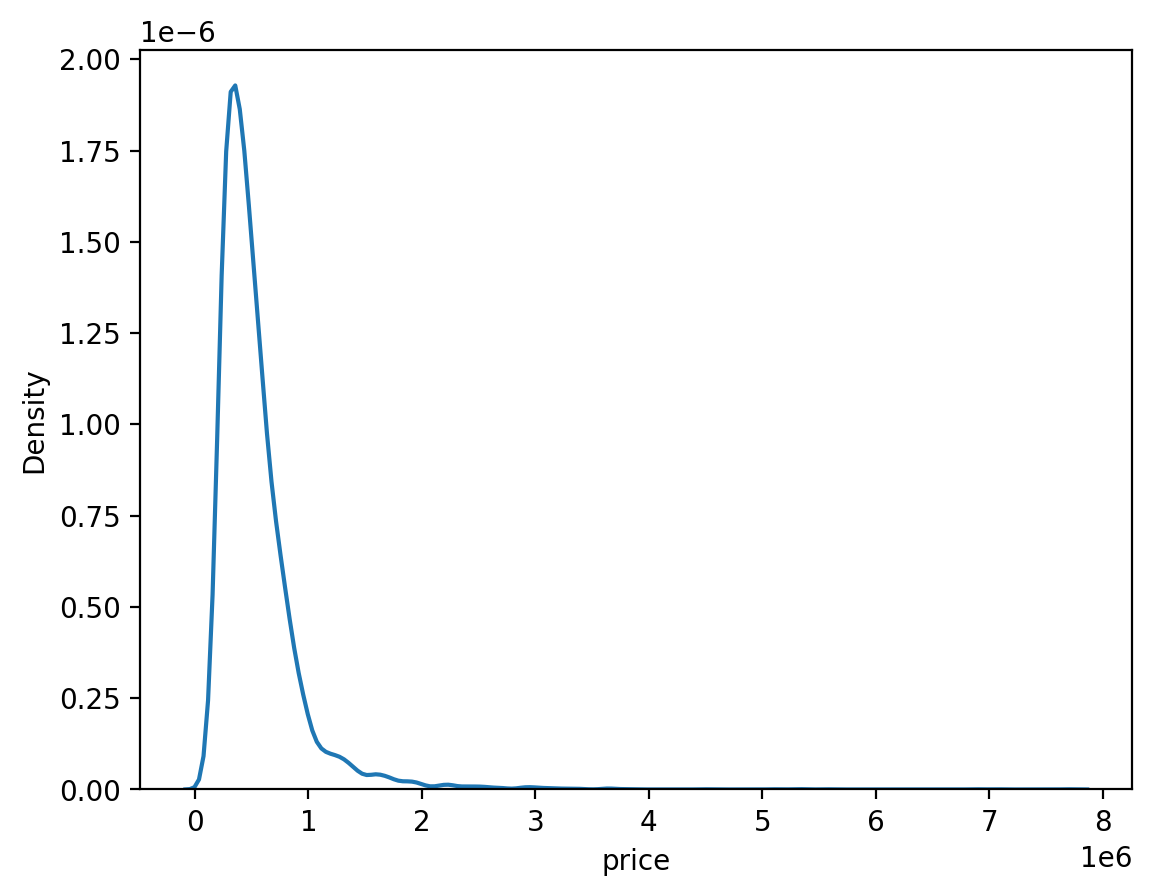

In [7]:
sns.kdeplot(y)
plt.show()

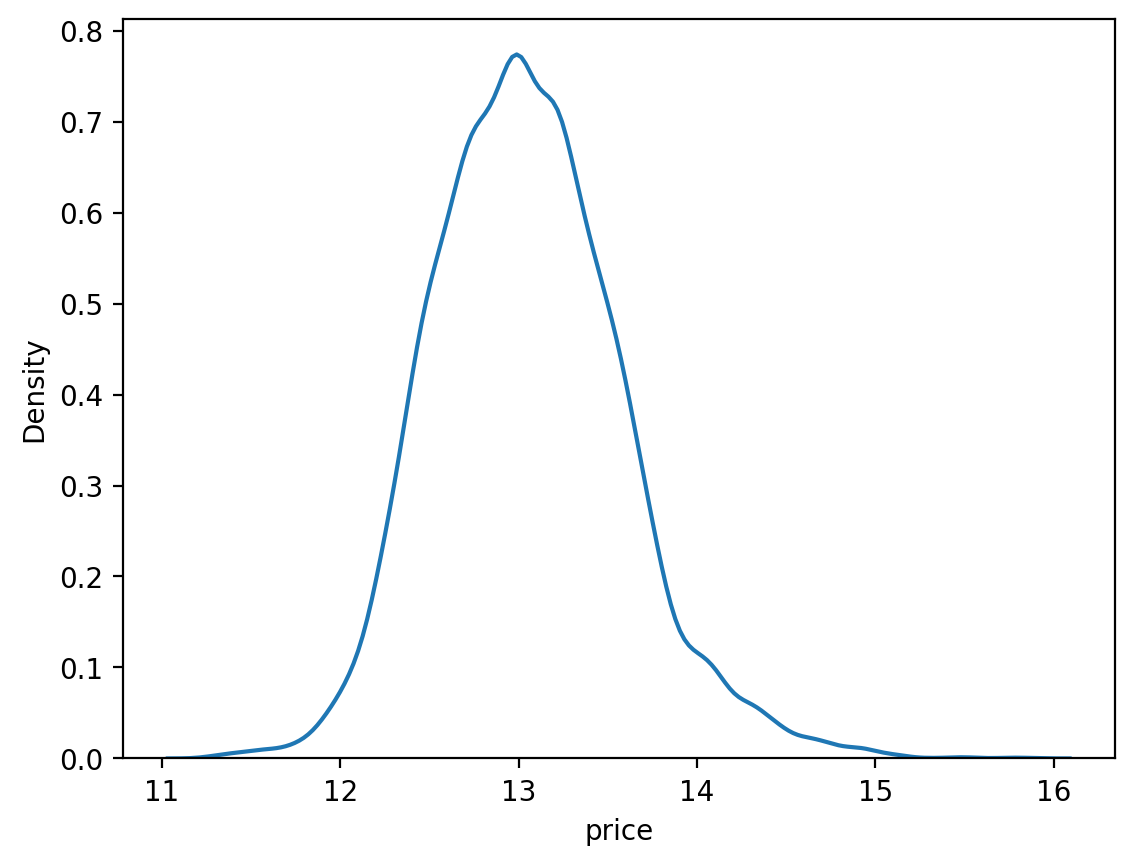

In [8]:
y = np.log1p(y)
y
sns.kdeplot(y)
plt.show()

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [11]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [12]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [13]:
random_state=42        

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]


In [14]:
gboost.__class__.__name__

'GradientBoostingRegressor'

In [15]:
df = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리
    # random_state를 사용하여 고정하고 train과 test 셋의 비율은 8:2로 합니다.
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)


    # 모델 학습
    model.fit(X_train, y_train)

    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)

    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

df

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002950 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2298
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 19
[LightGBM] [Info] Start training from score 13.047364


{'GradientBoostingRegressor': np.float64(134486.11621046875),
 'XGBRegressor': np.float64(129606.84410193958),
 'LGBMRegressor': np.float64(123071.46972897886),
 'RandomForestRegressor': np.float64(141073.87706816228)}

In [16]:
def get_scores(models, train, y):
    df = {}

    for model in models:
        model_name = model.__class__.__name__

        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

    return score_df

In [17]:
from sklearn.model_selection import GridSearchCV

In [18]:
#학습률 파라미터 추가
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
    'learning_rate':[0.1]
}

In [19]:
model = LGBMRegressor(random_state=random_state)

In [20]:
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003315 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2298
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 19
[LightGBM] [Info] Start training from score 13.035255
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

,estimator,LGBMRegressor(random_state=42)
,param_grid,"{'learning_rate': [0.1], 'max_depth': [1, 10], 'n_estimators': [50, 100]}"
,scoring,'neg_mean_squared_error'
,n_jobs,5
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,boosting_type,'gbdt'


In [21]:
grid_model.cv_results_

{'mean_fit_time': array([0.3665309 , 0.45126162, 0.75910344, 1.17954173]),
 'std_fit_time': array([0.05691232, 0.09384042, 0.04715662, 0.15459132]),
 'mean_score_time': array([0.03377442, 0.03656907, 0.0624722 , 0.05853844]),
 'std_score_time': array([0.02507546, 0.00936252, 0.00994181, 0.02794246]),
 'param_learning_rate': masked_array(data=[0.1, 0.1, 0.1, 0.1],
              mask=[False, False, False, False],
        fill_value=1e+20),
 'param_max_depth': masked_array(data=[1, 1, 10, 10],
              mask=[False, False, False, False],
        fill_value=999999),
 'param_n_estimators': masked_array(data=[50, 100, 50, 100],
              mask=[False, False, False, False],
        fill_value=999999),
 'params': [{'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 50},
  {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 100},
  {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 50},
  {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}],
 'split0_test_score': arra

In [22]:
params = grid_model.cv_results_['params']
params

[{'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 50},
 {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 100},
 {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 50},
 {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}]

In [23]:
score = grid_model.cv_results_['mean_test_score']
score

array([-0.07339447, -0.05502043, -0.02917734, -0.02702714])

In [24]:
results = pd.DataFrame(params)
results['score'] = score

results

,learning_rate,max_depth,n_estimators,score
0,0.1,1,50,-0.073394
1,0.1,1,100,-0.055020
2,0.1,10,50,-0.029177
3,0.1,10,100,-0.027027


In [25]:
results['RMSE'] = np.sqrt(-1 * results['score'])
results

,learning_rate,max_depth,n_estimators,score,RMSE
0,0.1,1,50,-0.073394,0.270914
1,0.1,1,100,-0.055020,0.234564
2,0.1,10,50,-0.029177,0.170814
3,0.1,10,100,-0.027027,0.164399


In [26]:
results = results.rename(columns={'RMSE': 'RMSLE'})
results

,learning_rate,max_depth,n_estimators,score,RMSLE
0,0.1,1,50,-0.073394,0.270914
1,0.1,1,100,-0.055020,0.234564
2,0.1,10,50,-0.029177,0.170814
3,0.1,10,100,-0.027027,0.164399


In [27]:
results = results.sort_values('RMSLE')
results

,learning_rate,max_depth,n_estimators,score,RMSLE
3,0.1,10,100,-0.027027,0.164399
2,0.1,10,50,-0.029177,0.170814
1,0.1,1,100,-0.055020,0.234564
0,0.1,1,50,-0.073394,0.270914


In [28]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)

    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score

    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [29]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


In [30]:
model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003254 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2338
[LightGBM] [Info] Number of data points in the train set: 15035, number of used features: 19
[LightGBM] [Info] Start training from score 13.048122


array([13.13580793, 13.08051399, 14.11202067, ..., 13.01592878,
       12.69894979, 12.96297768], shape=(6468,))

In [31]:
prediction = np.expm1(prediction)
prediction

array([ 506766.66784595,  479506.10405112, 1345155.15609376, ...,
        449515.92243642,  327402.87855805,  426332.71354302],
      shape=(6468,))

In [32]:
data_dir = '~/work/AIFFEL_quest_rs/Exploration/Ex02/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [33]:
submission['price'] = prediction
submission.head()

,id,price
0,15035,5.067667e+05
1,15036,4.795061e+05
2,15037,1.345155e+06
3,15038,3.122579e+05
4,15039,3.338645e+05


In [34]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.164399')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

~/work/AIFFEL_quest_rs/Exploration/Ex02/data/submission_lgbm_RMSLE_0.164399.csv


In [35]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = '~/work/AIFFEL_quest_rs/Exploration/Ex02/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [36]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.164399')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001481 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2338
[LightGBM] [Info] Number of data points in the train set: 15035, number of used features: 19
[LightGBM] [Info] Start training from score 13.048122
~/work/AIFFEL_quest_rs/Exploration/Ex02/data/submission_lgbm_RMSLE_0.164399.csv saved!


In [37]:
param_grid = {
    'n_estimators': [300, 500],
    'max_depth': [10, 50],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001501 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2338
[LightGBM] [Info] Number of data points in the train set: 15035, number of used features: 19
[LightGBM] [Info] Start training from score 13.048122


,max_depth,n_estimators,score,RMSLE
2,50,300,-0.026091,0.161527
0,10,300,-0.026127,0.161640
1,10,500,-0.026245,0.162004
3,50,500,-0.026340,0.162295


In [38]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.161527')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003993 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2338
[LightGBM] [Info] Number of data points in the train set: 15035, number of used features: 19
[LightGBM] [Info] Start training from score 13.048122
~/work/AIFFEL_quest_rs/Exploration/Ex02/data/submission_lgbm_RMSLE_0.161527.csv saved!


In [39]:
param_grid = {
    'n_estimators': [200, 300],
    'max_depth': [10, 50],
    'learning_rate': [0.1]
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.6s
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005688 seconds.
You 

,learning_rate,max_depth,n_estimators,score,RMSLE
3,0.1,50,300,-0.026091,0.161527
1,0.1,10,300,-0.026127,0.161640
0,0.1,10,200,-0.026188,0.161828
2,0.1,50,200,-0.026245,0.162003


In [40]:
param_grid = {
    'n_estimators': [300, 350],
    'max_depth': [50, 100],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.3s
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003999 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 12028, number o

,max_depth,n_estimators,score,RMSLE
0,50,300,-0.026091,0.161527
2,100,300,-0.026091,0.161527
1,50,350,-0.026153,0.161718
3,100,350,-0.026153,0.161718


In [41]:
param_grid = {
    'n_estimators': [300, 250],
    'max_depth': [50, 75],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001642 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2338
[LightGBM] [Info] Number of data points in the train set: 15035, number of used features: 19
[LightGBM] [Info] Start training from score 13.048122


,max_depth,n_estimators,score,RMSLE
0,50,300,-0.026091,0.161527
2,75,300,-0.026091,0.161527
1,50,250,-0.026127,0.161638
3,75,250,-0.026127,0.161638


In [42]:
param_grid = {
    'n_estimators': [300, 250],
    'max_depth': [50, 75],
    'subsample': [0.5, 1.0],
    'colsample_bytree': [0.7, 0.9]
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=2)


[LightGBM] [Info] Total Bins 2298
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 19
[LightGBM] [Info] Start training from score 13.035255
[CV] END ....................max_depth=100, n_estimators=350; total time=   3.1s
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001782 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2298
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 19
[LightGBM] [Info] Start training from score 13.035255
[CV] END .....................max_depth=50, n_estimators=300; total time=   3.1s
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007505 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total

,colsample_bytree,max_depth,n_estimators,subsample,score,RMSLE
0,0.7,50,300,0.5,-0.025796,0.160612
1,0.7,50,300,1.0,-0.025796,0.160612
5,0.7,75,300,1.0,-0.025796,0.160612
4,0.7,75,300,0.5,-0.025796,0.160612
3,0.7,50,250,1.0,-0.025807,0.160646
2,0.7,50,250,0.5,-0.025807,0.160646
6,0.7,75,250,0.5,-0.025807,0.160646
7,0.7,75,250,1.0,-0.025807,0.160646
8,0.9,50,300,0.5,-0.025988,0.161208
9,0.9,50,300,1.0,-0.025988,0.161208


In [43]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.160612')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001539 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2338
[LightGBM] [Info] Number of data points in the train set: 15035, number of used features: 19
[LightGBM] [Info] Start training from score 13.048122
~/work/AIFFEL_quest_rs/Exploration/Ex02/data/submission_lgbm_RMSLE_0.160612.csv saved!


In [47]:
```
###회고######
우선 프로젝트 기준 점수인 110000이하의 점수를 얻지 못했다.
    LMS에 주어진 코드 이외에 하이퍼 파라미터를 조정하여 RMSLE를 낮추는데에는
성공했지만, 0.160612 값이 최적의 값인지 더이상 내려가지않았다.
    그 후, 피쳐 엔지니어링을 통해 모델성능을 높이고자 했지만, 
코딩 전체적인 이해도 부족으로 수많은 에러 끝에 피쳐 엔지니어링에는 실패했다.
    기본적인 파이썬 함수들과 문법 구조 등등에 대한 기초적인 공부가 더 필요하다는
것을 뼈저리게 느낀 프로젝트였다. 지금시간,,, 새벽 다섯시,,, 최선을 다해봤지만,, 
망망대해 한 가운데에 있는 기분이다.. 기초지식이 없는만큼 공부를 더 많이 해야겠다.
    ```

SyntaxError: invalid syntax (1033035040.py, line 1)